## initial code for our Hand Gesture Recognition


In [10]:
# ML models imports
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.transform import probabilistic_hough_line
from skimage.feature import canny
from xgboost import XGBClassifier
from skimage.feature import local_binary_pattern
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern

# destribution models imports
from scipy.stats import randint, uniform

# Data manipulation imports
import numpy as np
import pandas as pd
import tqdm as tqdm

# visualisation models imports
import matplotlib.pyplot as plt

# image processing imports
import skimage.io as io
import cv2
from skimage.transform import resize

# dealing with files
import os

# visual dataset (to test randomized gridsearch not needed for now)
from sklearn.datasets import make_hastie_10_2  # to test our models

# from utils import prepareData, LoadData, FeatureExtraction, preprocess
import csv
import joblib


In [11]:
def segment_nu3(image):
    blured_image = cv2.GaussianBlur(image, (7, 7), 0)
    ycbcr_image = cv2.cvtColor(blured_image, cv2.COLOR_BGR2YCrCb)
    # Extract the Cr channel
    cr_channel = ycbcr_image[:, :, 1]

    # Apply thresholding to obtain a binary image
    _, binary_img = cv2.threshold(
        cr_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Define the structuring element for the closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (80, 80))

    # Define the structuring element for the eroding small noise
    smallKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    # Apply erosion to remove small noise
    eroded_img = cv2.morphologyEx(binary_img, cv2.MORPH_ERODE, smallKernel)
    # Perform the closing operation
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(
        eroded_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filling the contours on a copy of the original image
    # img_contours = cv2.cvtColor(cr_channel, cv2.COLOR_GRAY2BGR)
    # cv2.drawContours(img_contours, contours, -1, (0, 0, 0), -1)

    segmented_image = closed_img.copy()
    cv2.drawContours(segmented_image, contours, -1, 255, -1)

    return segmented_image


def chooseGamma(image):
    grayScale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    grayScale = np.array(grayScale)
    meanVal = np.mean(grayScale)
    if meanVal < 110:
        gamma = 2.5 
    elif meanVal < 115:
        gamma = 2.3
    elif meanVal < 120:
        gamma = 2.1
    elif meanVal < 125:
        gamma = 1.8
    elif meanVal < 130:
        gamma = 1.7
    elif meanVal < 135:
        gamma = 1.5
    elif meanVal < 140:
        gamma = 0.9
    elif meanVal < 145:
        gamma = 0.8
    elif meanVal < 150:
        gamma = 0.75
    else:
        gamma = 0.8

    return adjust_gamma(image, gamma)


def adjust_gamma(image, gamma=0.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


In [12]:
def choose_gamma(img, gamma_range=(0.2, 5.0), num_samples=50):
    """
    Choose the best gamma value to enhance an image based on its light.

    Parameters:
        img (numpy.ndarray): The input image.
        gamma_range (tuple): The range of gamma values to consider.
        num_samples (int): The number of gamma values to sample.

    Returns:
        float: The best gamma value.
    """
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Generate a list of gamma values to try
    gammas = np.linspace(gamma_range[0], gamma_range[1], num_samples)

    # Calculate the mean pixel intensity for each gamma value
    mean_intensities = []
    for gamma in gammas:
        adjusted_img = np.power(gray_img, gamma)
        mean_intensities.append(np.mean(adjusted_img))

    # Find the gamma value that produces the highest mean pixel intensity
    best_gamma_idx = np.argmax(mean_intensities)
    best_gamma = gammas[best_gamma_idx]

    adjusted_img = np.power(gray_img, best_gamma)

    # enhanced_img = cv2.cvtColor(adjusted_img, cv2.COLOR_GRAY2BGR)

    return adjusted_img


In [13]:
image = choose_gamma(io.imread('1_men (1).jpg'))


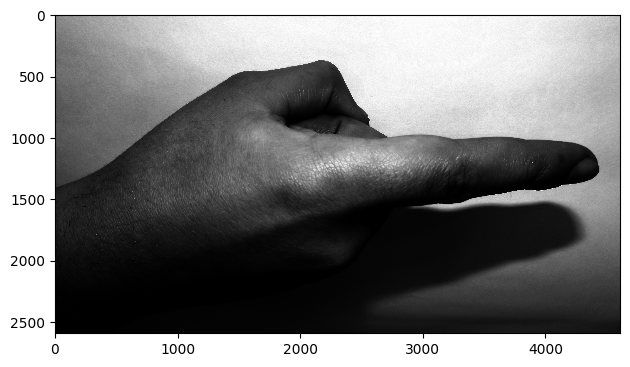

In [14]:
io.imshow((image/image.max()))


In [15]:
image = io.imread('Dataset/Women/4/4_woman (131).JPG')
image = chooseGamma(image)
segmented = segment(image)
io.imshow(segmented)

NameError: name 'segment' is not defined

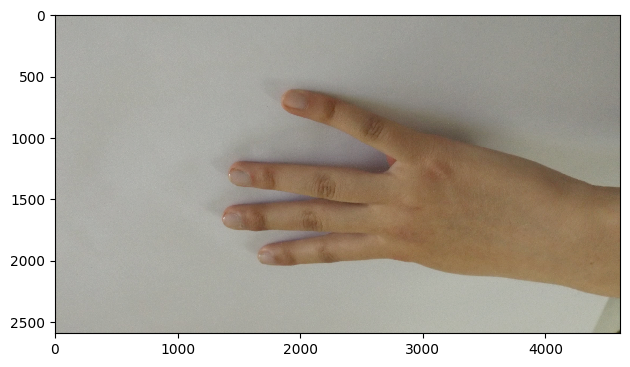

In [ ]:
gammed = chooseGamma(image)
io.imshow(gammed)

In [30]:
def segment(image):
    blured_image = cv2.GaussianBlur(image, (7, 7), 0)
    ycbcr_image = cv2.cvtColor(blured_image, cv2.COLOR_BGR2YCrCb)
    # Extract the Cr channel
    cr_channel = ycbcr_image[:, :, 1]

    # Apply thresholding to obtain a binary image
    _, binary_img = cv2.threshold(
        cr_channel, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Define the structuring element for the closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))

    # Perform the closing operation
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)

    # Find the contours in the binary image
    contours, hierarchy = cv2.findContours(
        closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filling the contours on a copy of the original image
    # img_contours = cv2.cvtColor(cr_channel, cv2.COLOR_GRAY2BGR)
    # cv2.drawContours(img_contours, contours, -1, (0, 0, 0), -1)

    segmented_image = closed_img.copy()
    cv2.drawContours(segmented_image, contours, -1, 255, -1)

    return segmented_image


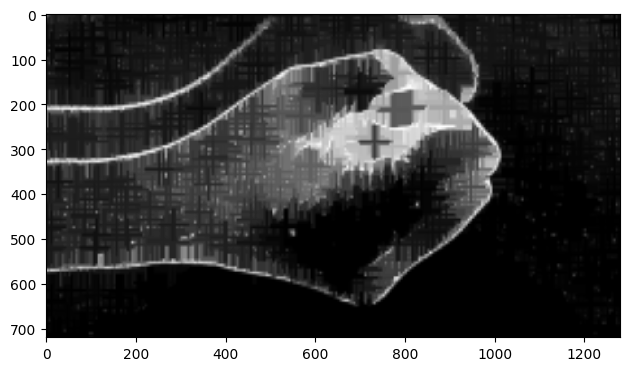

In [ ]:
io.imshow(resize(noPlanB(img),(img.shape[0],img.shape[1])))

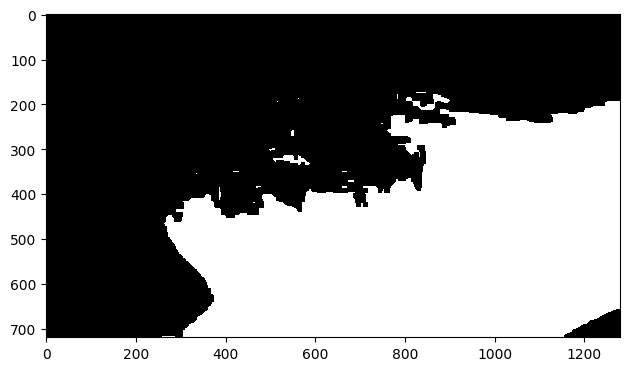

In [ ]:
io.imshow(segment(io.imread('shit_2.jpg')))

In [16]:
def nu3mnyagd3aan(image):
    segmented = segment(img)

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    image_B = resize(noPlanB(img),(img.shape[0],img.shape[1]))

    # result =result + image_B.astype(np.uint8)

    return ((segmented & gray).astype(np.uint8)) | (100*image_B).astype(np.uint8)

In [17]:
img = io.imread('1_men (1).jpg')

io.imshow(nu3mnyagd3aan(img))

NameError: name 'segment' is not defined

In [18]:
def featureScalingUsingSklearn(features):
    '''
        Inputs:
            features: the features to be scaled
        Outputs:
            scaledFeatures: the scaled features
        Note: 
            this function is used to scale the features to be in the range [0,1]
            this is done by subtracting the minimum value from each feature and then dividing by the range
            of the feature.
        Reference: 
            https://stackabuse.com/feature-scaling-data-with-scikit-learn-for-machine-learning-in-python/
    '''
    scaler = StandardScaler()
    scaledFeatures = scaler.fit_transform(features)
    return scaledFeatures


In [19]:
def Blobs(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Laplacian of Gaussian (LoG) filter
    log = cv2.GaussianBlur(gray, (5, 5), 0)
    log = cv2.Laplacian(log, cv2.CV_8U, ksize=5)

    # Threshold the filtered image to obtain a binary image
    _, binary = cv2.threshold(log, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    # Apply morphological operations to remove noise and fill gaps in the blobs
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    # Detect and extract the blobs using the SimpleBlobDetector in OpenCV
    params = cv2.SimpleBlobDetector_Params()
    params.minThreshold = 0
    params.maxThreshold = 255
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(binary)

    extracted_blobs = []

    for kp in keypoints:
        f = extract_from_keypoint(kp)
        extracted_blobs.append(f)

    return np.asarray(extracted_blobs).flatten()


In [20]:
def extract_from_keypoint(kp):
    # Extract relevant attributes from keypoint
    x, y = kp.pt
    size = kp.size
    angle = kp.angle
    # Compute and normalize the angle in the range [0, 1)
    angle = angle / 360.0
    if angle < 0:
        angle += 1.0

    # Create a feature array
    features = np.array([x, y, size, angle], dtype=np.float32)

    return features


In [21]:
def Princibal_Component_Analysis(X, k):
    pca = PCA(n_components = k)
    X_pca = pca.fit_transform(X)
    return X_pca

In [22]:
def try_all(img, sigma=7, sec=25, block_size=11, threshold=cv2.ADAPTIVE_THRESH_GAUSSIAN_C):
    blured_image = cv2.GaussianBlur(img, (sigma, sigma), 0)
    
    gray = cv2.cvtColor(blured_image, cv2.COLOR_BGR2GRAY)

    # gray = cv2.cvtColor(blured_image, cv2.COLOR_BGR2GRAY)
    binary_img = cv2.adaptiveThreshold(gray, 255, threshold, cv2.THRESH_BINARY_INV, block_size, 2)
    
    
    # Define the structuring element for the closing operation
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (sec, sec))
    # Perform the closing operation
    closed_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, kernel)
    
    contours, hierarchy = cv2.findContours(closed_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmented_image = closed_img.copy()
    cv2.drawContours(segmented_image, contours, -1, 255, -1)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (sec, sec))
    segmented_image = cv2.morphologyEx(segmented_image, cv2.MORPH_CLOSE, kernel)
    
    return segmented_image

In [23]:
io.imshow(segment(io.imread('1_men (1).jpg')))

NameError: name 'segment' is not defined

In [24]:
def noPlanB(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    binary_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 2)
    kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (13, 13))
    binary_img = cv2.morphologyEx(resize(binary_img,(128,256)), cv2.MORPH_CLOSE, kernel)

    

    return binary_img 


c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


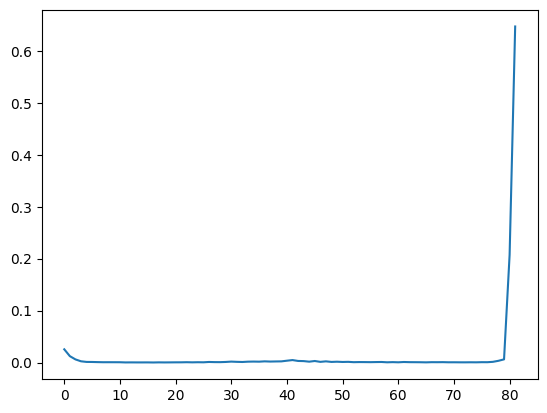

In [25]:
# gray = cv2.cvtColor(io.imread('1_men (1).jpg'), cv2.COLOR_BGR2GRAY)
# binary_img = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 19, 2)
# kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (13, 13))
# binary_img = cv2.morphologyEx(resize(binary_img,(128,256)), cv2.MORPH_CLOSE, kernel)

# # # Find the contours in the binary image
# # contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # segmented_image = binary_img.copy()
# # cv2.drawContours(segmented_image, contours, -1, 255, -1)


img = noPlanB(io.imread('shit_2.jpg'))
# io.imshow(img)|
# Apply LBP
radius = 10
n_points = 8 * radius
lbp = local_binary_pattern(img, n_points, radius, method='uniform')
hist, _ = np.histogram(lbp.ravel(), bins=np.arange(
    0, n_points + 3), range=(0, n_points + 2))
hist = hist.astype('float')
hist /= (hist.sum() + 1e-7)

plt.plot(hist)



In [26]:
def NU3U(originalImage):
    image = chooseGamma(originalImage)
    mask = segment(image)
    # image=cv2.bitwise_and(originalImage,originalImage,mask=mask)
    # image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return mask


In [27]:
def numStraightLines(image):
    edges = canny(image, 2, 1, 25)
    lines = probabilistic_hough_line(
        edges, threshold=10, line_length=5, line_gap=3)
    return len(lines)


In [75]:
def HUFunction(img):
    '''
        this is a utility function used to evaluate the HU features which 
        are 7, which are invarient with size, rotation and transition. 
        inputs:
            img: the original Img
        outputs:
            the huMoments. 
    '''
    # Calculate Moments
    moments = cv2.moments(img)
    # Calculate Hu Moments
    huMoments = cv2.HuMoments(moments)

    return huMoments

In [151]:
def FeatureExtraction(image):

    # Extract the hog features
    # block_norm uses L2 norm with hysterisis for reducing effect of illuminacity
    # transform_sqrt for applying gamma correction
    # preprocessed_image = segment(image)

    # glcm = graycomatrix(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), distances=[1], angles=[0], symmetric=True, normed=True)

    # contrast = graycoprops(glcm, 'contrast')
    # dissimilarity = graycoprops(glcm, 'dissimilarity')
    # homogeneity = graycoprops(glcm, 'homogeneity')
    # energy = graycoprops(glcm, 'energy')
    # correlation = graycoprops(glcm, 'correlation')




    # img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # # Apply LBP
    # radius = 10
    # n_points = 8 * radius
    # lbp = local_binary_pattern(img_gray, n_points, radius, method='uniform')
    # hist, _ = np.histogram(lbp.ravel(), bins=np.arange(
    #     0, n_points + 3), range=(0, n_points + 2))
    # hist = hist.astype('float')
    # hist /= (hist.sum() + 1e-7)

    
    Hu_M = HUFunction(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY))

    # gamma = chooseGamma(image)
    # resized_image = resize(image,(512, 1024))

    preprocessed_image = segment(image)

    # resized_image = resize(preprocessed_image,(64,128))   # downscaing from approx 2500x4000 to 500x500
    resized_image = resize(preprocessed_image, (64, 128))

    hog_features = hog(resized_image, block_norm='L2-Hys', feature_vector=True,
                    transform_sqrt=True, pixels_per_cell=(12, 12), cells_per_block=(2, 2))

                    
    # pca = Princibal_Component_Analysis(hog_features.reshape(1,-1),10)
    # print(correlation[0])
    # print(Hu_M.flatten())

    features = np.concatenate(((Hu_M.flatten()).reshape(-1,1), hog_features.reshape(-1,1)), axis=0)
    # print(hog_features.shape)

    return np.squeeze(features)


In [152]:
image =  cv2.imread('1_men (1).JPG')
F = FeatureExtraction(image)
print(F)
print(F.shape)



[1.02460332e-03 3.13685277e-07 6.92001561e-12 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
(1303,)


In [164]:
def LoadData():
    Features = []
    labels = []

    i = 0
    for gender in ["men", "Women"]:
        datadir = r"dataset_no3\{}".format(gender)
        # loop over gender
        for hand in os.listdir(datadir):
            # loop over each class [0,1,2,3,4,5]
            for img in os.listdir(datadir + "/" + str(hand)):
                # ignoring anything except images
                if ((img.split('.')[-1]).lower() not in ['jpg', 'png', 'jpeg']):
                    continue

                # loading our images
                # approx 2500 * 4000
                img_array = io.imread(datadir + "/" + str(hand) + "/" + img)

                # append extracted features to Featurees list
                Feature = FeatureExtraction(img_array)
                Features.append(Feature)

                # append class of image.
                labels.append(int(hand))

                print(f'image Number: {i}')
                i += 1

    return np.asarray(Features), np.asarray(labels)


In [165]:
Features, labels = LoadData()

image Number: 0
image Number: 1
image Number: 2
image Number: 3
image Number: 4
image Number: 5
image Number: 6
image Number: 7
image Number: 8
image Number: 9
image Number: 10
image Number: 11
image Number: 12
image Number: 13
image Number: 14
image Number: 15
image Number: 16
image Number: 17
image Number: 18
image Number: 19
image Number: 20
image Number: 21
image Number: 22
image Number: 23
image Number: 24
image Number: 25
image Number: 26
image Number: 27
image Number: 28
image Number: 29
image Number: 30
image Number: 31
image Number: 32
image Number: 33
image Number: 34
image Number: 35
image Number: 36
image Number: 37
image Number: 38
image Number: 39
image Number: 40
image Number: 41
image Number: 42
image Number: 43
image Number: 44
image Number: 45
image Number: 46
image Number: 47
image Number: 48
image Number: 49
image Number: 50
image Number: 51
image Number: 52
image Number: 53
image Number: 54
image Number: 55
image Number: 56
image Number: 57
image Number: 58
image N

In [154]:
Features[:,:].shape


(59, 1303)

In [14]:
import cv2
import numpy as np


# Load the grayscale image
img_gray = cv2.imread('1_men (1).JPG', cv2.IMREAD_GRAYSCALE)


# Apply GLCM
glcm = graycomatrix(img_gray, distances=[1], angles=[0], symmetric=True, normed=True)
contrast = graycoprops(glcm, 'contrast')
dissimilarity = graycoprops(glcm, 'dissimilarity')
homogeneity = graycoprops(glcm, 'homogeneity')
energy = graycoprops(glcm, 'energy')
correlation = graycoprops(glcm, 'correlation')

# Apply LBP
radius = 10
n_points = 8 * radius
lbp = local_binary_pattern(img_gray, n_points, radius, method='uniform')
print(len(lbp))
hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
hist = hist.astype('float')
hist /= (hist.sum() + 1e-7)

# Print the feature values
print('GLCM Features:')
print(f'Contrast: {contrast}')
print(f'Dissimilarity: {dissimilarity}')
print(f'Homogeneity: {homogeneity}')
print(f'Energy: {energy}')
print(f'Correlation: {correlation}')

print('LBP Features:')
print(len(hist))


2592
GLCM Features:
Contrast: [[1.53515517]]
Dissimilarity: [[0.73566493]]
Homogeneity: [[0.68702441]]
Energy: [[0.05325467]]
Correlation: [[0.99970942]]
LBP Features:
82


In [61]:
print(hist)

[0.03778294 0.01992325 0.01443318 0.01358095 0.01179963 0.01261477
 0.01067579 0.01280432 0.01511847 0.01862895 0.02248966 0.03087692
 0.03097898 0.02941334 0.0239612  0.02035033 0.01766662 0.019263
 0.01591552 0.01873511 0.02154474 0.02439054 0.03111127 0.02189354
 0.08849018 0.41555681]


In [166]:
np.save('Labels_cleaned_no3.npy', labels)
np.save('Features_cleaned_no3.npy', Features)
# labels=np.load('Labels.npy')
# Features=np.load('Features.npy')
len(labels)
# len(Features)


1713

0.0

In [197]:
# Use Pandas to read the CSV file in chunks of 1000 rows
# chunk_size = 10
# for chunk in pd.read_csv('Features.csv', chunksize=chunk_size):
#     # Process each chunk of data here
#     print(chunk.head())


In [198]:
# test = np.load('Features/1.npy')
# test.max()


In [199]:
# img = cv2.imread('1_men (2).JPG')
# lower_rgb=np.array([0, 0, 0],dtype="uint8")
# upper_rgb=np.array([230, 230, 230],dtype="uint8")
# skin_region=cv2.inRange(img,lower_rgb,upper_rgb)
# cv2.imwrite("segmented_2.jpg",skin_region)


In [191]:
def testOurModel(path):
    '''
       this is a utility function used to load the test data
    '''

    Features = []
    datadir = path
    # loop over gender
    i = 1

    # for i in range(1,55):
    #     # ignoring anything except images
    #     # if((img.split('.')[-1]).lower() not in ['jpg', 'png', 'jpeg']):
    #     #     continue


    #     # loading our images
    #     img_array = io.imread(f'{datadir}/({i}).jpg')
    #     print(i)
    #     images.append(img_array)
    #     # append extracted features to Featurees list
    #     Features.append(FeatureExtraction(img_array))
    #     i+=1

    for i in range(55,116):
        # ignoring anything except images
        # if((img.split('.')[-1]).lower() not in ['jpg', 'png', 'jpeg']):
        #     continue

        # loading our images
        img_array = io.imread(f'{datadir}/({i}).jpeg')
        print(i)

        # append extracted features to Featurees list
        Features.append(FeatureExtraction(img_array))
        # i+=1

    # here i have features need to pass them to my model

    svm = joblib.load('model_2_All_Images_HOG_HU.pkl')

    y_pred = svm.predict(pd.DataFrame(Features))

    return y_pred


def readFinalResults(resultFilePath):
    ''' 
        this is a utility function used to read the 
        file which contains the actual results for 
        the test data. 
        input:
            resultFilePath: the path of the file which contains the actual results for the test data.
        output:
            results: the actual results for the test data.
    '''
    results = []
    with open(resultFilePath, 'r') as resultFile:
        for line in resultFile:
            results.append(int(line.strip()))
    
    return results

In [192]:
labels = readFinalResults('kamal_results.txt')
print(labels)


[5, 4, 3, 3, 2, 2, 1, 1, 1, 2, 3, 4, 4, 5, 0, 0, 1, 2, 3, 4, 5, 0, 0, 5, 5, 4, 3, 3, 3, 2, 5, 4, 4, 3, 3, 1, 1, 0, 0, 1, 2, 4, 1, 1, 0, 0, 0, 2, 2, 5, 1, 2, 2, 1, 3, 3, 4, 4, 3, 5, 5]


In [194]:
y_pred = testOurModel('testData')

55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115


In [195]:
print(y_pred,labels)

[5 4 5 0 5 2 1 2 1 2 4 4 4 3 0 3 1 2 5 4 5 0 0 5 3 3 3 2 4 2 5 3 4 4 3 1 1
 0 0 1 3 4 1 2 0 0 0 3 2 5 1 2 3 1 3 3 4 4 3 3 5] [5, 4, 3, 3, 2, 2, 1, 1, 1, 2, 3, 4, 4, 5, 0, 0, 1, 2, 3, 4, 5, 0, 0, 5, 5, 4, 3, 3, 3, 2, 5, 4, 4, 3, 3, 1, 1, 0, 0, 1, 2, 4, 1, 1, 0, 0, 0, 2, 2, 5, 1, 2, 2, 1, 3, 3, 4, 4, 3, 5, 5]


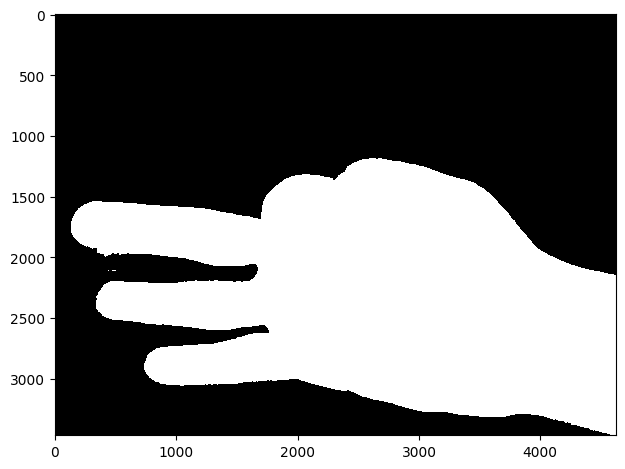

In [74]:
io.imshow(segment(io.imread('testData\(5).jpg')))

In [196]:
print(1-(np.sum(labels != y_pred))/len(labels))

0.6885245901639344


In [68]:
missClassified = labels != y_pred
missClassified

array([False,  True, False,  True,  True, False,  True, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True,  True,  True, False,  True,  True,  True,
       False,  True, False, False,  True, False, False, False,  True,
       False, False,  True,  True,  True, False, False,  True, False,
        True,  True, False, False, False, False,  True, False, False,
        True, False, False, False, False, False,  True, False, False,
        True,  True, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False,  True, False, False, False, False,  True, False,
       False, False, False, False, False,  True, False])

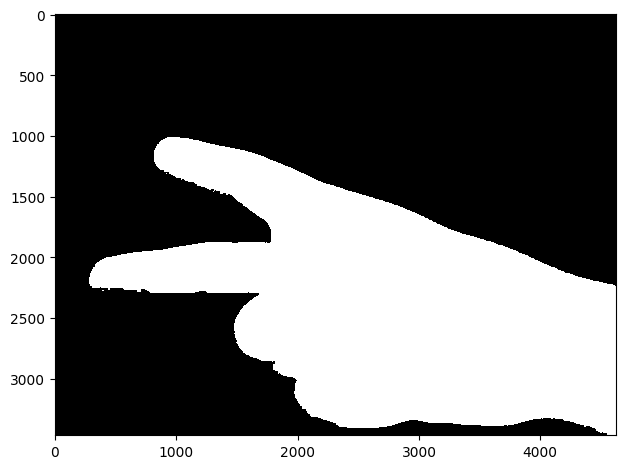

In [73]:

io.imshow(segment(io.imread('testData\(4).jpg')))
    

In [77]:
HUFunction(io.imread('testData\(4).jpg',as_gray=True))

array([[ 3.04574608e-01],
       [ 8.05041462e-03],
       [ 8.81736057e-05],
       [ 2.77437459e-04],
       [ 1.66852447e-09],
       [ 2.45035035e-07],
       [-4.33606368e-08]])

- # Selecting the best model


- ### Define hyperparameter grids for each model


In [167]:
param_distributions = {
    'RandomForestClassifier': {
        'n_estimators': randint(50, 500),
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'GradientBoostingClassifier': {
        'learning_rate': uniform(0.01, 0.2),
        'n_estimators': randint(50, 500),
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'SVC': {
        'C': range(1,100,1),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4, 5, 6],
        'gamma': ['scale', 'auto'] + list(np.arange(0.1, 1, 0.1)),
        'coef0': [-1, 0, 1],
        'shrinking': [True, False],
        'probability': [True, False],
        'tol': [1e-5, 1e-4, 1e-3],
        'max_iter': range(-1,1000,50)
    },
    'LogisticRegression': {
        'C': uniform(0.01, 10),
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'max_iter': randint(50, 500)
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': randint(2, 20),
        'min_samples_split': randint(2, 10),
        'min_samples_leaf': randint(1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'KNeighborsClassifier': {
        'n_neighbors': randint(3, 30),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(10, 100)
    },
    'GaussianNB': {
        'var_smoothing': uniform(1e-09, 1e-07)
    },
    'MLPClassifier': {
        'hidden_layer_sizes': [(50, 50), (100,), (100, 50)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'alpha': uniform(0.0001, 0.01),
        'max_iter': randint(100, 1000)
    },
    'XGBClassifier': {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 3,
        'min_child_weight': 1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 0,
        'alpha': 0,
        'lambda': 1,
        'num_boost_round': 100
    }
}


- ### Create a list of models to train (as example)


In [168]:
models = [
    SVC()
]


In [169]:
Features.shape

(1713, 1303)

- ### Loop over the models and fit


In [171]:
# load our dummy data to test the randomizedSearche function
x, y = Features, labels
df = pd.DataFrame(x)
df['Y'] = y

# this function shuffles the data points, and splits the data into
train, test = train_test_split(df, test_size=0.1)
# 80% training set and 20% test set (indicated by test_size=0.2)
X_train, Y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, Y_test = test.iloc[:, :-1], test.iloc[:, -1]


In [172]:
len(X_train)

1541

In [20]:
from sklearn.metrics import mean_absolute_error
xgb_model = XGBClassifier(random_state=0)
xgb_model.fit(X_train, Y_train)
y_pred = xgb_model.predict(X_test)


print(1-(np.sum(y_pred != Y_test))/len(Y_test))


0.791970802919708


In [173]:
svm = SVC(C= 10, coef0 = 1, degree= 4, gamma= 5, kernel= 'poly', max_iter= 1000, probability= True, shrinking= True ,tol= 1e-05) 
svm.fit(X_train, Y_train)
y_pred = svm.predict(X_test)

print(1-(np.sum(y_pred != Y_test))/len(Y_test))


0.8197674418604651


c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [174]:
print(len(Y_train),len(y_pred))

1541 172


In [175]:
for i, model in enumerate(models):
    print(f'Training Model {i+1}/{len(models)}: {str(model)[:-2]}')
    # Define randomized grid search
    # n_jobs means number of jobs to run in parallel. None means 1,
    random_search = RandomizedSearchCV(
        model, param_distributions[str(model)[:-2]],n_iter=100, cv=5, n_jobs=-1)
    # -1 means using all processors 😈.
    # Fit the randomized grid search to the data
    random_search.fit(X_train, Y_train)
    print(f'Best score: {random_search.best_score_:.3f}')
    print(f'Best parameters: {random_search.best_params_}\n')
    with open("analysis.txt", "a") as file:
    # Write some text to the file

        file.write(f'Training Model {i+1}/{len(models)}: {str(model)[:-2]}\n')
        file.write(f'Best score: {random_search.best_score_:.3f}\n')
        file.write(f'Best parameters: {random_search.best_params_}\n')
        file.write("\n\n\n")


Training Model 1/1: SVC
Best score: 0.835
Best parameters: {'tol': 1e-05, 'shrinking': True, 'probability': False, 'max_iter': 199, 'kernel': 'poly', 'gamma': 0.6, 'degree': 3, 'coef0': 1, 'C': 51}



c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=199).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [186]:
svm = SVC(tol= 1e-05, shrinking= True, probability= False, max_iter= 1000, kernel= 'poly', gamma= 0.6, degree= 3, coef0= 1, C= 51) 
svm.fit(X_train, Y_train)
y_pred = svm.predict(X_test)

print(1-(np.sum(y_pred != Y_test))/len(Y_test))

0.8313953488372093


c:\Users\Khaled Hesham\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [187]:
joblib.dump(svm, 'model_2_All_Images_HOG_HU.pkl')

['model_2_All_Images_HOG_HU.pkl']

In [41]:
SVM = joblib.load('model_2_All_Images_HOG_Only.pkl')
y_pred = SVM.predict(X_train)

print(1-(np.sukm(y_pred != Y_train))/len(Y_train))


0.9773755656108597
